# 라이브러리

In [1]:
! pip3 install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 데이터 불러오기

In [3]:
log_path = "/content/drive/MyDrive/코드잇_데이터분석_6기/프로젝트/데이터 분석 중급 프로젝트_1/원본 데이터/주제 1. 국내 채용시장 및 채용 플랫폼 이용패턴 분석/이전 분석/log_df.csv"
log_df = pd.read_csv(log_path)

In [4]:
# 1. UTC 제거
log_df["timestamp_clean"] = log_df["timestamp"].str.replace(" UTC", "", regex=False)

# 2. datetime으로 변환
log_df["timestamp_clean"] = pd.to_datetime(
    log_df["timestamp_clean"],
    format="%Y-%m-%d %H:%M:%S.%f",
    errors="coerce"
)

# 3. NaT가 생긴 경우, 포맷이 다른 문자열을 다시 처리 (마이크로초 없는 경우 등)
mask_failed = log_df["timestamp_clean"].isna()
log_df.loc[mask_failed, "timestamp_clean"] = pd.to_datetime(
    log_df.loc[mask_failed, "timestamp"].str.replace(" UTC", "", regex=False),
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

# 4. 정리
log_df["timestamp"] = log_df["timestamp_clean"]
log_df.drop(columns="timestamp_clean", inplace=True)

In [5]:
# 쿼리 파라미터 제거
log_df["cleaned_url"] = log_df["URL"].str.split("?").str[0]

# Acquisition

In [6]:
cleaned_unique_urls = log_df["cleaned_url"].unique()

acquisition_keywords = [
    "signup",
    "signup/step1",
    "signup/step2",
    "signup/step3",
    "api/signup"
]

# Acquisition URL로 분류
acquisition_urls = [url for url in cleaned_unique_urls if isinstance(url, str) and any(kw in url for kw in acquisition_keywords)]

In [7]:
# 가입 관련 URL 방문 로그 추출
acquisition_logs = log_df[log_df["cleaned_url"].isin(acquisition_urls)]

# Acquisition 퍼널 세분화 (done_df)

In [8]:
# clean_url 만들기
acquisition_logs["clean_url"] = acquisition_logs["cleaned_url"].str.lower()

# 퍼널 단계 정의
funnel_stages = {
    "detail": ["detail"],
    "step1": ["signup/step1"],
    "step2": ["signup/step2"],
    "step3": ["signup/step3"]
}

# 퍼널 단계 부여 함수
def assign_funnel_stage(url):
    url = str(url).lower()
    for stage, keywords in funnel_stages.items():
        if any(k in url for k in keywords):
            return stage
    return "other"

# funnel_stage 컬럼 생성
acquisition_logs["funnel_stage"] = acquisition_logs["clean_url"].apply(assign_funnel_stage)

<ipython-input-8-de0dcc257111>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acquisition_logs["clean_url"] = acquisition_logs["cleaned_url"].str.lower()
<ipython-input-8-de0dcc257111>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acquisition_logs["funnel_stage"] = acquisition_logs["clean_url"].apply(assign_funnel_stage)


In [9]:
detail_stage = acquisition_logs[acquisition_logs["funnel_stage"] == "detail"]
detail_members = detail_stage["user_uuid"].unique()
detail_numbers = detail_stage["user_uuid"].nunique()

detail_df = acquisition_logs[acquisition_logs['user_uuid'].isin(detail_members)].reset_index(drop=True)

# detail -> step1
step_1_stage = detail_df[detail_df["funnel_stage"] == "step1"]

step_1_members = step_1_stage["user_uuid"].unique()

step_1_stage = detail_df[detail_df["funnel_stage"] == "step1"]
step_1_members = step_1_stage["user_uuid"].unique()
step_1_numbers = step_1_stage["user_uuid"].nunique()

step_1_df = detail_df[detail_df['user_uuid'].isin(step_1_members)].reset_index(drop=True)

# step1 -> step2
step_2_stage = step_1_df[step_1_df["funnel_stage"] == "step2"]
step_2_members = step_2_stage["user_uuid"].unique()
step_2_numbers = step_2_stage["user_uuid"].nunique()

step_2_df = step_1_df[step_1_df['user_uuid'].isin(step_2_members)].reset_index(drop=True)

# step2 -> step3
step_3_stage = step_2_df[step_2_df["funnel_stage"] == "step3"]
step_3_members = step_3_stage["user_uuid"].unique()
step_3_numbers = step_3_stage["user_uuid"].nunique()

step_3_df = step_2_df[step_2_df['user_uuid'].isin(step_3_members)].reset_index(drop=True)
done_df = step_3_df[step_3_df["cleaned_url"] == "signup/step3/done"]
done_numbers = done_df["user_uuid"].nunique()

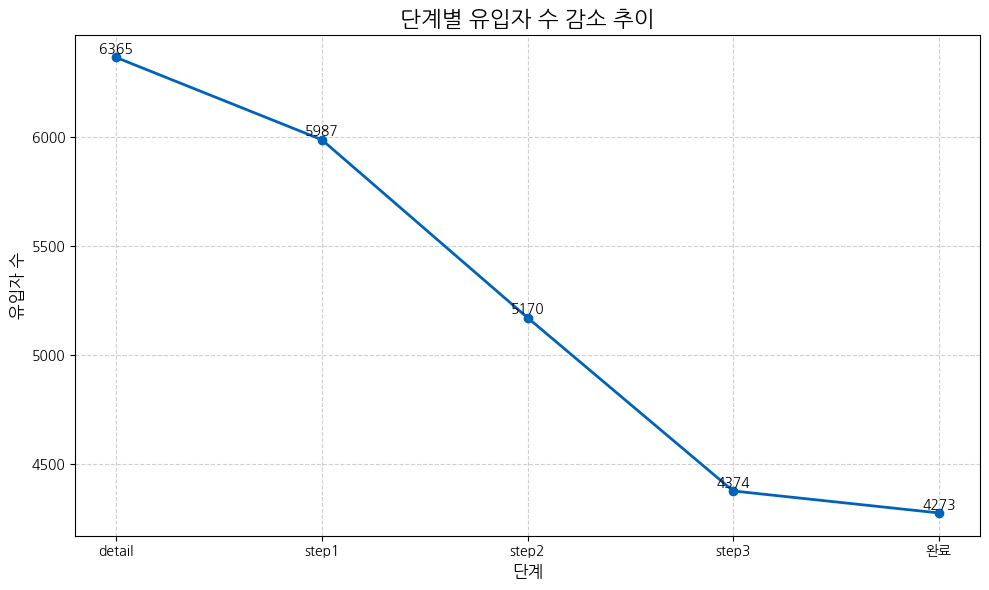

In [10]:
# 단계 이름과 유입자 수 (너의 실제 값으로 바꿔줘)
stage_names = ["detail", "step1", "step2", "step3", "완료"]
counts = [detail_numbers, step_1_numbers, step_2_numbers, step_3_numbers, done_numbers]

# 선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(stage_names, counts, marker='o', linestyle='-', color='#0063ba', linewidth=2)
plt.title("단계별 유입자 수 감소 추이", fontsize=16)
plt.xlabel("단계", fontsize=12)
plt.ylabel("유입자 수", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# 각 점에 유입자 수 표시
for i, count in enumerate(counts):
    plt.text(i, count + 20, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [11]:
del detail_stage
del detail_members
del detail_df
del step_1_stage
del step_1_members
del step_1_df
del step_2_stage
del step_2_members
del step_2_df
del step_3_stage
del step_3_members
del step_3_df

# Activation 퍼널 세분화 (apply_step_4_api_df)

In [12]:
cleaned_unique_urls = log_df["cleaned_url"].unique()

activation_keywords = ["jobs/id/apply"]

# activation_urls URL로 분류
activation_urls = [url for url in cleaned_unique_urls if isinstance(url, str) and any(kw in url for kw in activation_keywords)]

singup_done_members = done_df["user_uuid"].unique()
acquisition_to_activation_df = log_df[log_df["user_uuid"].isin(singup_done_members)]

# 지원 관련 URL 방문 로그 추출
activation_logs = acquisition_to_activation_df[acquisition_to_activation_df["cleaned_url"].isin(activation_urls)]

In [13]:
# 회원가입 완료한 사람 (detail, step1, 2, 3 모두 가보고 done으로 도달한 사람)
done_df["user_uuid"].nunique()

4273

In [14]:
# 회원가입 한 4273명 중에서 apply(지원)을 시도한 사람의 수
activation_logs["user_uuid"].nunique()

4153

In [15]:
activation_logs = activation_logs.sort_values("timestamp")

apply_step_1_df = activation_logs[activation_logs["cleaned_url"] == "jobs/id/apply/step1"]

apply_step_1_number = apply_step_1_df["user_uuid"].nunique()

apply_step_1_members = apply_step_1_df["user_uuid"].unique()

step_1_df = activation_logs[activation_logs["user_uuid"].isin(apply_step_1_members)]

apply_step_2_df = step_1_df[step_1_df["cleaned_url"] == "jobs/id/apply/step2"]

apply_step_2_number = apply_step_2_df["user_uuid"].nunique()

apply_step_2_members = apply_step_2_df["user_uuid"].unique()

step_2_df = activation_logs[activation_logs["user_uuid"].isin(apply_step_2_members)]

apply_step_3_df = step_2_df[step_2_df["cleaned_url"] == "jobs/id/apply/step3"]

apply_step_3_number = apply_step_3_df["user_uuid"].nunique()

apply_step_3_members = apply_step_3_df["user_uuid"].unique()

step_3_df = activation_logs[activation_logs["user_uuid"].isin(apply_step_3_members)]

apply_step_4_df = step_3_df[step_3_df["cleaned_url"] == "jobs/id/apply/step4"]

apply_step_4_number = apply_step_4_df["user_uuid"].nunique()

apply_step_4_members = apply_step_4_df["user_uuid"].unique()

step_4_df = activation_logs[activation_logs["user_uuid"].isin(apply_step_4_members)]

apply_step_4_api_df = step_4_df[step_4_df["cleaned_url"] == "api/jobs/id/apply/step4"]

apply_step_4_api_number = apply_step_4_api_df["user_uuid"].nunique()

In [16]:
del activation_logs
del apply_step_1_df
del apply_step_1_members
del step_1_df
del apply_step_2_df
del apply_step_2_members
del step_2_df
del apply_step_3_df
del apply_step_3_members
del step_3_df
del apply_step_4_df
del apply_step_4_members
del step_4_df

In [17]:
# 단계별 유입자 수
stage_names = ["step1", "step2", "step3", "step4", "완료"]
counts = [apply_step_1_number, apply_step_2_number, apply_step_3_number, apply_step_4_number, apply_step_4_api_number]

# 기준이 되는 상세 페이지 진입 수
base_number = counts[0]

# 백분율 계산: 각 단계의 유입자 수 / 상세 페이지 진입 수 * 100
percentage_rates = [round((count / base_number) * 100, 2) for count in counts]

# 이탈률 계산
dropoff_rates = []
for i in range(len(counts) - 1):
    rate = (counts[i] - counts[i+1]) / counts[i]
    dropoff_rates.append(round(rate * 100, 2))
dropoff_rates.append(0.0)  # 완료 단계에서는 이탈률 없음

# 표 생성
df = pd.DataFrame({
    "단계": stage_names,
    "유입자 수": counts,
    "이탈률 (%)": dropoff_rates,
    "백분율 (%)": percentage_rates
})

df

,단계,유입자 수,이탈률 (%),백분율 (%)
0,step1,4145,0.68,100.00
1,step2,4117,11.61,99.32
2,step3,3639,0.41,87.79
3,step4,3624,0.06,87.43
4,완료,3622,0.00,87.38


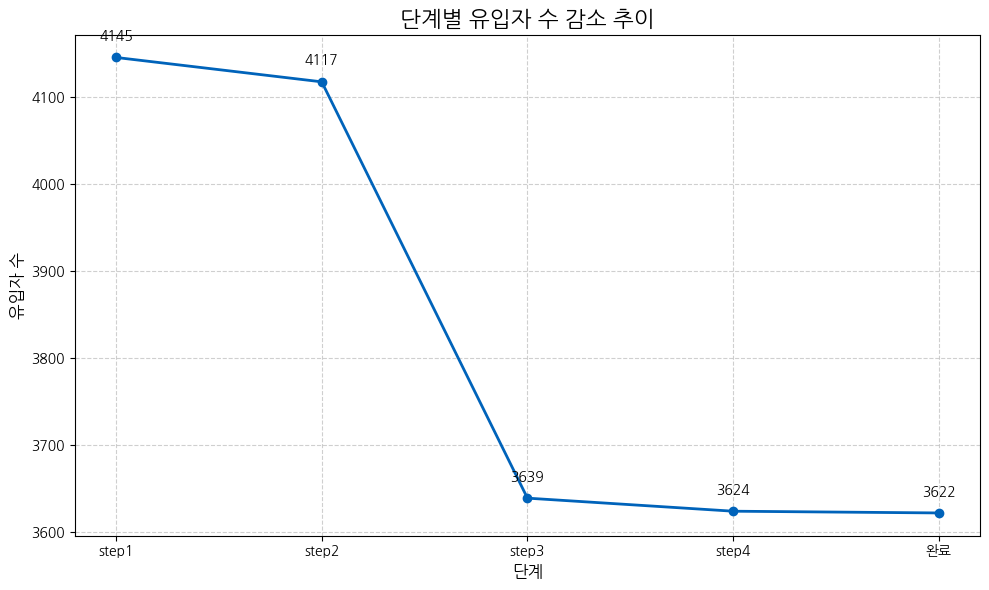

In [18]:
# 단계 이름과 유입자 수 (너의 실제 값으로 바꿔줘)
stage_names = ["step1", "step2", "step3", "step4", "완료"]
counts = [apply_step_1_number, apply_step_2_number, apply_step_3_number, apply_step_4_number, apply_step_4_api_number]

# 선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(stage_names, counts, marker='o', linestyle='-', color='#0063ba', linewidth=2)
plt.title("단계별 유입자 수 감소 추이", fontsize=16)
plt.xlabel("단계", fontsize=12)
plt.ylabel("유입자 수", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# 각 점에 유입자 수 표시
for i, count in enumerate(counts):
    plt.text(i, count + 20, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [19]:
activated_members = apply_step_4_api_df["user_uuid"].astype(str).unique().tolist()

activated_members_set = set(activated_members)

# log_2022_df에서 activated_members_set 값을 가지는 행 필터링
log_df["user_uuid"] = log_df["user_uuid"].astype(str)
activation_members_df = log_df[log_df["user_uuid"].isin(activated_members_set)]

activation_members_df.groupby("user_uuid")

# timestamp 기준으로 정렬
activation_members_df = activation_members_df.sort_values(by="timestamp")
activation_members_df = activation_members_df.reset_index(drop=True)

In [20]:
# "apply/step4"이 처음 등장한 인덱스를 기록할 딕셔너리 생성
first_apply_index = {}

# 그룹화 후 각 유저별로 처리
for user, group in activation_members_df.groupby("user_uuid"):
    # "api/jobs/id/apply/step4"이 있는 행 필터링
    apply_rows = group[group["cleaned_url"] == "api/jobs/id/apply/step4"]

    # 만약 해당 URL이 존재하면, 그 중 첫 번째 인덱스를 저장
    if not apply_rows.empty:
        first_index = apply_rows.index[0]
        first_apply_index[user] = first_index

# 삭제 기준 인덱스 목록 만들기
rows_to_keep = []
for user, group in activation_members_df.groupby("user_uuid"):
    if user in first_apply_index:
        # 해당 유저에서 apply/step4가 처음 등장한 인덱스 이후부터 유지
        idx_to_keep = group.loc[first_apply_index[user]:].index
        rows_to_keep.extend(idx_to_keep)

# 최종 결과: 필요한 행만 유지
after_apply_df = activation_members_df.loc[rows_to_keep].reset_index(drop=True)

## 범위 리텐션

- 각 유저별 최초 지원 완료일 기준 7일(30일)간 활동 내역이 있으면 유지

<ipython-input-22-449e5d02d20a>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  weekly_retention_binary = weekly_retention_pivot.applymap(lambda x: 1 if x > 0 else 0)
<ipython-input-22-449e5d02d20a>:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f"{y:.0%}" for y in plt.gca().get_yticks()])


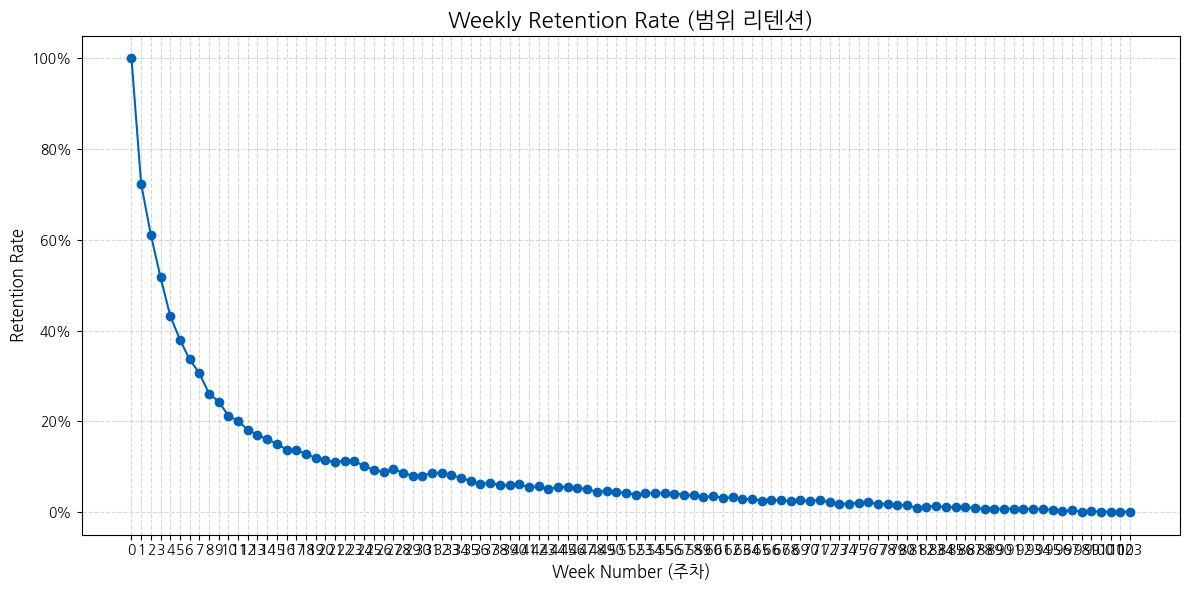

In [22]:
# 지원한 시점 기준으로 유저별 최초 지원일 구하기
apply_logs = after_apply_df[after_apply_df["cleaned_url"] == "api/jobs/id/apply/step4"]
first_apply = apply_logs.groupby("user_uuid")["timestamp"].min().reset_index()
first_apply.columns = ["user_uuid", "first_apply_time"]

# 원본 데이터에 최초 지원일 병합
range_df = after_apply_df.merge(first_apply, on="user_uuid", how="left")

# 최초 지원일로부터 경과일 수 계산
range_df["timestamp"] = pd.to_datetime(range_df["timestamp"])
range_df["first_apply_time"] = pd.to_datetime(range_df["first_apply_time"])
range_df["days_since_apply"] = (range_df["timestamp"] - range_df["first_apply_time"]).dt.days

# 7일 단위 주차로 그룹핑 (0주차 = Day 0~6, 1주차 = Day 7~13, ...)
range_df["week_number"] = (range_df["days_since_apply"] // 7)

# 유저별 활동한 주차 정보 추출
weekly_retention = range_df.groupby(["user_uuid", "week_number"]).size().reset_index(name="activity_count")

# Pivot: retention table 생성
weekly_retention_pivot = weekly_retention.pivot_table(index="user_uuid", columns="week_number", values="activity_count", fill_value=0)

# Binary 형태로 변환 (해당 주차에 활동했으면 1)
weekly_retention_binary = weekly_retention_pivot.applymap(lambda x: 1 if x > 0 else 0)

# 전체 유저 수로 나눠서 각 주차별 유지율 계산
weekly_retention_rate = weekly_retention_binary.sum(axis=0) / weekly_retention_binary.shape[0]

# 보기 좋게 정리
weekly_retention_rate_df = weekly_retention_rate.reset_index()
weekly_retention_rate_df.columns = ["week", "retention_rate"]
weekly_retention_rate_df["week"] = weekly_retention_rate_df["week"].astype(int)
weekly_retention_rate_df = weekly_retention_rate_df.sort_values("week").reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(weekly_retention_rate_df["week"], weekly_retention_rate_df["retention_rate"], marker="o", color="#0063ba")

plt.title("Weekly Retention Rate (범위 리텐션)", fontsize=16)
plt.xlabel("Week Number (주차)", fontsize=12)
plt.ylabel("Retention Rate", fontsize=12)
plt.xticks(weekly_retention_rate_df["week"])  # 모든 주차 보이게
plt.grid(True, linestyle="--", alpha=0.5)

# y축 퍼센트 포맷
plt.gca().set_yticklabels([f"{y:.0%}" for y in plt.gca().get_yticks()])

plt.tight_layout()
plt.show()

<ipython-input-23-3b1094fd50ed>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  monthly_retention_binary = monthly_retention_pivot.applymap(lambda x: 1 if x > 0 else 0)
<ipython-input-23-3b1094fd50ed>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f"{y:.0%}" for y in plt.gca().get_yticks()])


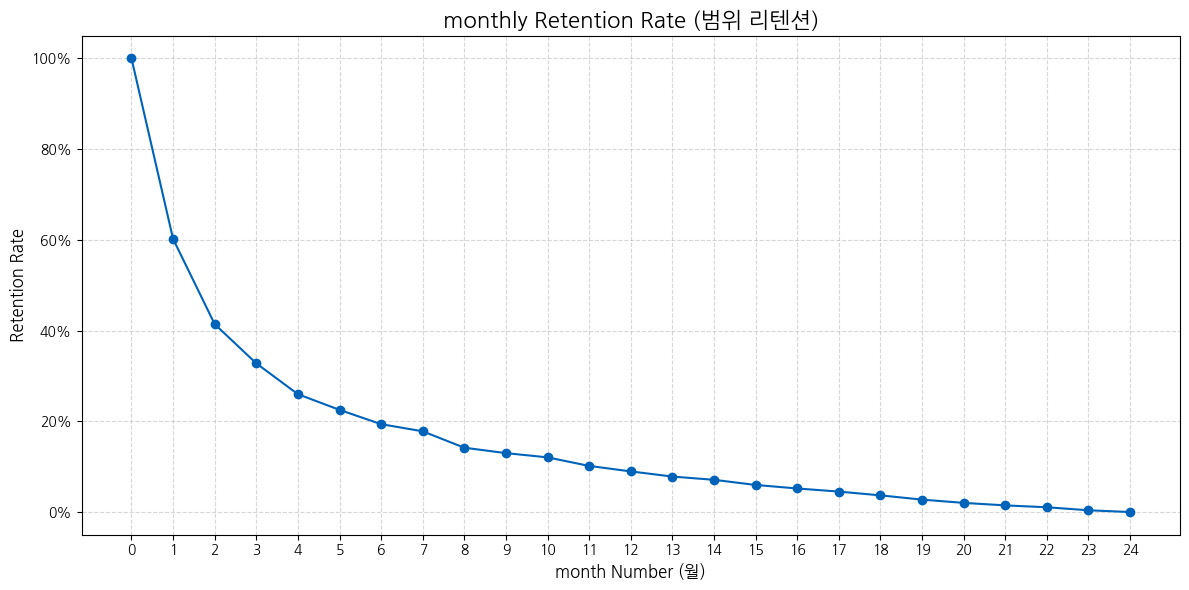

In [23]:
# 7일 단위 주차로 그룹핑 (0주차 = Day 0~6, 1주차 = Day 7~13, ...)
range_df["month_number"] = (range_df["days_since_apply"] // 30)

# 유저별 활동한 주차 정보 추출
monthly_retention = range_df.groupby(["user_uuid", "month_number"]).size().reset_index(name="activity_count")

# Pivot: retention table 생성
monthly_retention_pivot = monthly_retention.pivot_table(index="user_uuid", columns="month_number", values="activity_count", fill_value=0)

# Binary 형태로 변환 (해당 주차에 활동했으면 1)
monthly_retention_binary = monthly_retention_pivot.applymap(lambda x: 1 if x > 0 else 0)

# 전체 유저 수로 나눠서 각 주차별 유지율 계산
monthly_retention_rate = monthly_retention_binary.sum(axis=0) / monthly_retention_binary.shape[0]

# 보기 좋게 정리
monthly_retention_rate_df = monthly_retention_rate.reset_index()
monthly_retention_rate_df.columns = ["month", "retention_rate"]
monthly_retention_rate_df["month"] = monthly_retention_rate_df["month"].astype(int)
monthly_retention_rate_df = monthly_retention_rate_df.sort_values("month").reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(monthly_retention_rate_df["month"], monthly_retention_rate_df["retention_rate"], marker="o", color="#0063ba")

plt.title("monthly Retention Rate (범위 리텐션)", fontsize=16)
plt.xlabel("month Number (월)", fontsize=12)
plt.ylabel("Retention Rate", fontsize=12)
plt.xticks(monthly_retention_rate_df["month"])  # 모든 주차 보이게
plt.grid(True, linestyle="--", alpha=0.5)

# y축 퍼센트 포맷
plt.gca().set_yticklabels([f"{y:.0%}" for y in plt.gca().get_yticks()])

plt.tight_layout()
plt.show()

## 클래식 리텐션

- 각 유저별 최초 지원 완료일 기준 7일(30일)이 되는 날 활동 내역이 있으면 유지

<ipython-input-24-9f3aa3431d69>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classic_retention_df["week"] = classic_retention_df["days_since_apply"] // 7
<ipython-input-24-9f3aa3431d69>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f"{y:.0%}" for y in plt.gca().get_yticks()])


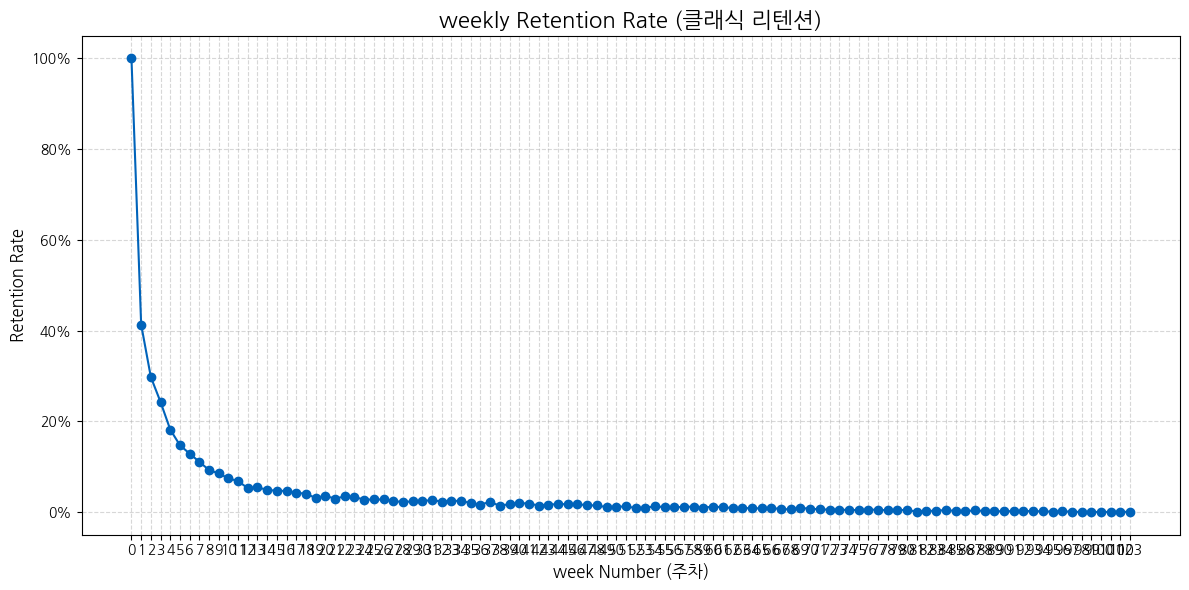

In [24]:
# 원본 데이터에 최초 지원일 병합
classic_df = after_apply_df.merge(first_apply, on="user_uuid", how="left")

# 최초 지원일로부터 경과일 수 계산
classic_df["timestamp"] = pd.to_datetime(classic_df["timestamp"])
classic_df["first_apply_time"] = pd.to_datetime(classic_df["first_apply_time"])
classic_df["days_since_apply"] = (classic_df["timestamp"] - classic_df["first_apply_time"]).dt.days

# 7일, 14일, 21일, 28일 ...
classic_retention_df = classic_df[classic_df["days_since_apply"] % 7 == 0]

# 각 row에 해당하는 'week' 정보 추가
classic_retention_df["week"] = classic_retention_df["days_since_apply"] // 7

# 최초 지원자 수 (week 0 기준 active 사용자 수)
week0_users = classic_retention_df[classic_retention_df["week"] == 0]["user_uuid"].nunique()

# week별 리텐션 계산: 각 주차에 한 번이라도 접속한 유저 수 / 최초 유저 수
weekly_classic_retention = (
    classic_retention_df.groupby("week")["user_uuid"]
    .nunique()
    .reset_index()
    .rename(columns={"user_uuid": "retained_users"})
)
weekly_classic_retention["retention_rate"] = weekly_classic_retention["retained_users"] / week0_users

plt.figure(figsize=(12, 6))
plt.plot(weekly_classic_retention["week"], weekly_classic_retention["retention_rate"], marker="o", color="#0063ba")

plt.title("weekly Retention Rate (클래식 리텐션)", fontsize=16)
plt.xlabel("week Number (주차)", fontsize=12)
plt.ylabel("Retention Rate", fontsize=12)
plt.xticks(weekly_classic_retention["week"])  # 모든 주차 보이게
plt.grid(True, linestyle="--", alpha=0.5)

# y축 퍼센트 포맷
plt.gca().set_yticklabels([f"{y:.0%}" for y in plt.gca().get_yticks()])

plt.tight_layout()
plt.show()

<ipython-input-25-aab249bbbc38>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classic_retention_df["month"] = classic_retention_df["days_since_apply"] // 30
<ipython-input-25-aab249bbbc38>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f"{y:.0%}" for y in plt.gca().get_yticks()])


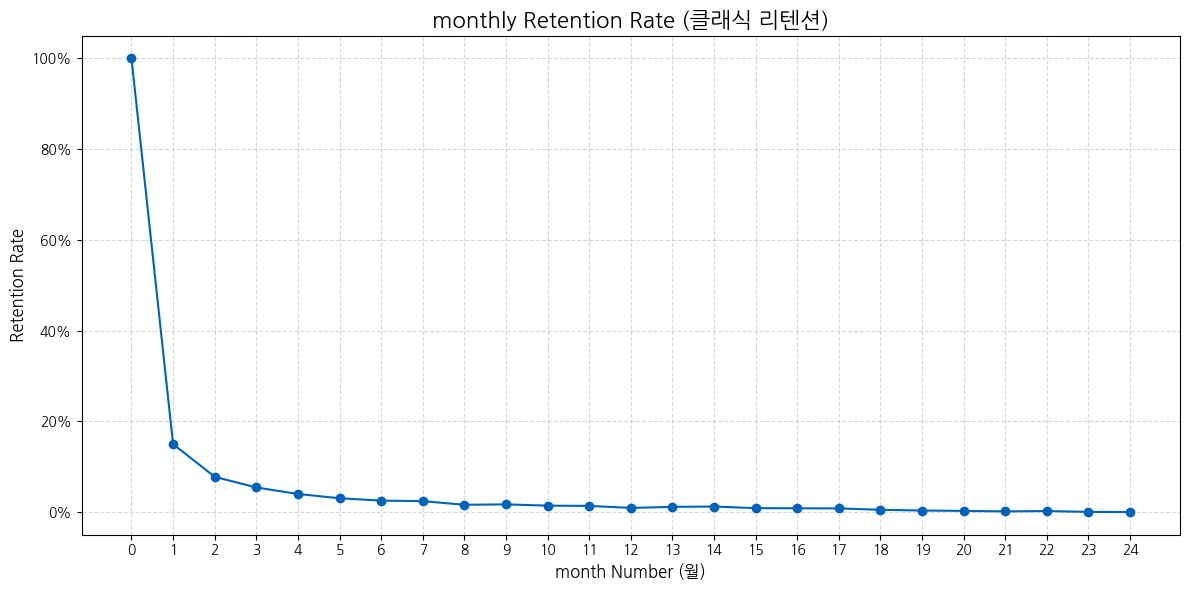

In [25]:
# 7일, 14일, 21일, 28일 ...
classic_retention_df = classic_df[classic_df["days_since_apply"] % 30 == 0]

# 각 row에 해당하는 'week' 정보 추가
classic_retention_df["month"] = classic_retention_df["days_since_apply"] // 30

# 최초 지원자 수 (week 0 기준 active 사용자 수)
month0_users = classic_retention_df[classic_retention_df["month"] == 0]["user_uuid"].nunique()

# week별 리텐션 계산: 각 주차에 한 번이라도 접속한 유저 수 / 최초 유저 수
monthly_classic_retention = (
    classic_retention_df.groupby("month")["user_uuid"]
    .nunique()
    .reset_index()
    .rename(columns={"user_uuid": "retained_users"})
)
monthly_classic_retention["retention_rate"] = monthly_classic_retention["retained_users"] / month0_users

plt.figure(figsize=(12, 6))
plt.plot(monthly_classic_retention["month"], monthly_classic_retention["retention_rate"], marker="o", color="#0063ba")

plt.title("monthly Retention Rate (클래식 리텐션)", fontsize=16)
plt.xlabel("month Number (월)", fontsize=12)
plt.ylabel("Retention Rate", fontsize=12)
plt.xticks(monthly_classic_retention["month"])  # 모든 주차 보이게
plt.grid(True, linestyle="--", alpha=0.5)

# y축 퍼센트 포맷
plt.gca().set_yticklabels([f"{y:.0%}" for y in plt.gca().get_yticks()])

plt.tight_layout()
plt.show()

## 롤링 리텐션

- 각 유저별 최초 지원 완료일 기준 n일 이후 한번이라도 활동이 있으면 유지

In [26]:
# 롤링 리텐션 함수 정의
def calculate_user_level_rolling_retention(df, rolling_days=7):
    """
    각 유저의 base_date를 기준으로 Day N Rolling Retention 계산

    Parameters:
    - df: DataFrame with columns ['user_uuid', 'date']
    - rolling_days: int, 몇 일 뒤까지 재방문을 보는지

    Returns:
    - retention_rate: 전체 유저 중 유지된 유저 비율
    - retained_users: 유지된 유저 리스트
    - total_users: 전체 유저 수
    """
    df['date'] = pd.to_datetime(df['date'])
    first_visits = df.groupby('user_uuid')['date'].min().reset_index().rename(columns={'date': 'base_date'})

    # base_date를 원래 데이터에 병합
    df = df.merge(first_visits, on='user_uuid', how='left')

    # 각 유저가 base_date + N일 이후로 재방문한 기록이 있는지 확인
    df['retention_cutoff'] = df['base_date'] + pd.Timedelta(days=rolling_days)
    df['retained'] = df['date'] >= df['retention_cutoff']

    # 재방문 여부를 유저 단위로 계산
    retained_users = df[df['retained']].groupby('user_uuid').size().index.tolist()
    total_users = first_visits['user_uuid'].nunique()
    retention_rate = len(retained_users) / total_users if total_users > 0 else 0

    return retention_rate, retained_users, total_users

In [27]:
retention_rate, retained_users, total_users = calculate_user_level_rolling_retention(after_apply_df, rolling_days=7)

print(f"전체 유저 수: {total_users}명")
print(f"7일 롤링 리텐션 유지 유저 수: {len(retained_users)}명")
print(f"리텐션율: {retention_rate:.2%}")

전체 유저 수: 3622명
7일 롤링 리텐션 유지 유저 수: 3257명
리텐션율: 89.92%


In [28]:
retention_rate, retained_users, total_users = calculate_user_level_rolling_retention(after_apply_df, rolling_days=30)

print(f"전체 유저 수: {total_users}명")
print(f"30일 롤링 리텐션 유지 유저 수: {len(retained_users)}명")
print(f"리텐션율: {retention_rate:.2%}")

전체 유저 수: 3622명
30일 롤링 리텐션 유지 유저 수: 2752명
리텐션율: 75.98%


In [29]:
retention_rate, retained_users, total_users = calculate_user_level_rolling_retention(after_apply_df, rolling_days=60)

print(f"전체 유저 수: {total_users}명")
print(f"60일 롤링 리텐션 유지 유저 수: {len(retained_users)}명")
print(f"리텐션율: {retention_rate:.2%}")

전체 유저 수: 3622명
60일 롤링 리텐션 유지 유저 수: 2282명
리텐션율: 63.00%


## 활성화 유저 월별 코호트 리텐션

- 코호트 리텐션 하는 이유 (월별 기준)
    - 2023년 이유
        - 왜곡이 발생하니깐 각 유저별 유지율을 계산 하기보다는
        - 지원 월을 기준으로 코호트 세분화를 하여 1월 달에 지원한 사람은 2 ~ 12월에 대한 리텐션, 5월 달에 지원한 사람은 6 ~ 12월에 대한 리텐션을 구하자

    - 추가로 월별 코호트 리텐션 구한 후 주차별 코호트 리텐션도 구해볼 수 있음

In [30]:
df = apply_step_4_api_df.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"])

# apply 로그만 필터링
apply_logs = df[df["cleaned_url"] == "api/jobs/id/apply/step4"]

# 유저별 최초 지원일 (코호트 기준)
apply_logs["cohort_date"] = apply_logs.groupby("user_uuid")["timestamp"].transform("min")

# 전체 로그에 유저별 cohort 정보 병합
df = df.merge(apply_logs[["user_uuid", "cohort_date"]].drop_duplicates(), on="user_uuid", how="left")

# 월 단위로 변환
df["cohort_date"] = df["cohort_date"].dt.to_period("M").apply(lambda r: r.start_time)
df["event_month"] = df["timestamp"].dt.to_period("M").apply(lambda r: r.start_time)

# 코호트 내 경과 월 계산
df["month_index"] = ((df["event_month"] - df["cohort_date"]) / pd.Timedelta(days=30)).astype(int)

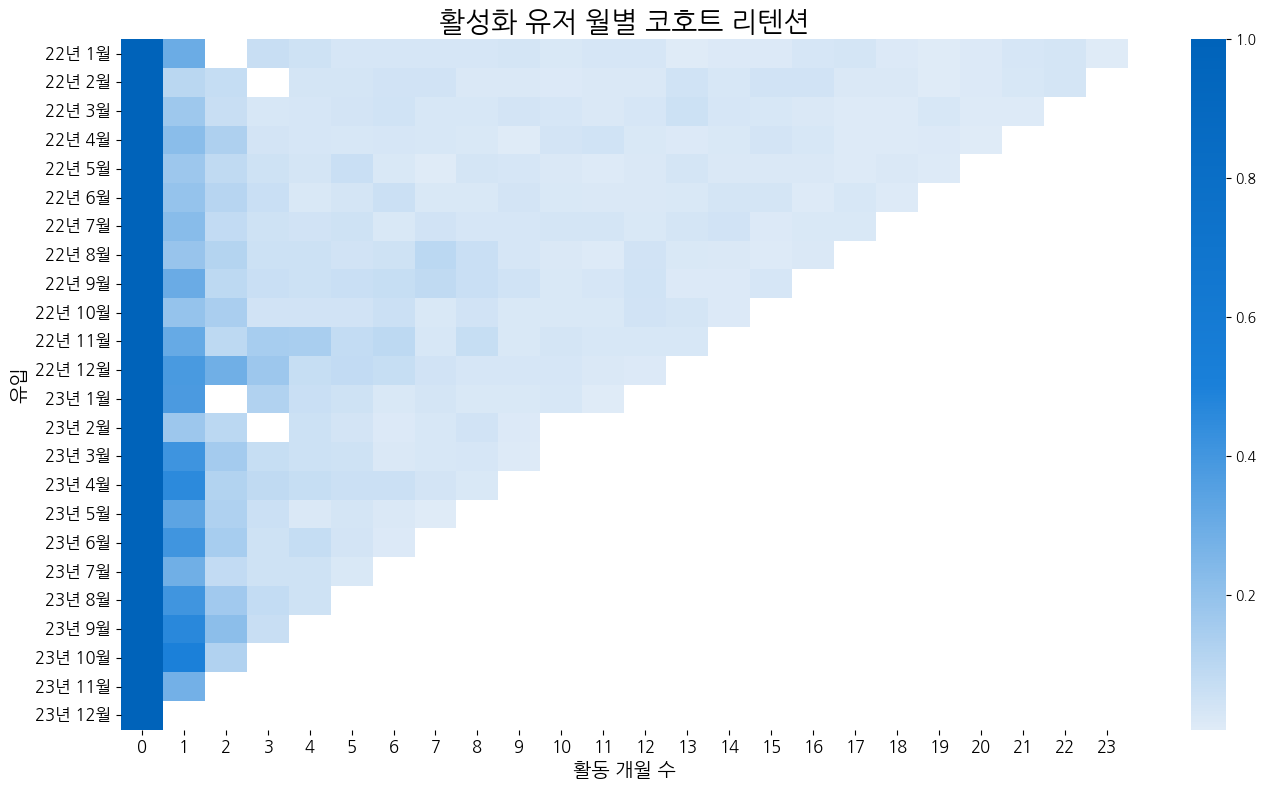

In [31]:
# 유저 수 집계
cohort_data = df.groupby(["cohort_date", "month_index"])["user_uuid"].nunique().reset_index()

# 피벗 테이블로 변환
cohort_pivot = cohort_data.pivot(index="cohort_date", columns="month_index", values="user_uuid")

# 각 코호트의 최초 유저 수
cohort_sizes = cohort_pivot.iloc[:, 0]

# 리텐션율 계산
retention = cohort_pivot.divide(cohort_sizes, axis=0)

from matplotlib.colors import LinearSegmentedColormap

# 컬러맵
colors = ["#dfebf7", "#1a80d9", "#0063ba"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

plt.figure(figsize=(14, 8))  # 조금 더 크게
sns.heatmap(retention, annot=False, cmap=custom_cmap)

# 제목과 축 폰트 사이즈 조정
plt.title("활성화 유저 월별 코호트 리텐션", fontsize=20)
plt.xlabel("활동 개월 수", fontsize=14)
plt.ylabel("유입", fontsize=14)

# y축 날짜 포맷 수정
new_labels = [f"{d.year % 100}년 {d.month}월" for d in retention.index]
plt.yticks(ticks=np.arange(len(new_labels)) + 0.5, labels=new_labels, fontsize=12)

# x축, y축 눈금 글자 크기 키우기
plt.xticks(fontsize=12)  # x축 살짝 기울이기
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# 합격자

## 최종 합격한 사람 (@user_id/applications?status=passed)

In [32]:
log_passed_members = log_df[log_df['URL'] == "@user_id/applications?status=passed"]["user_uuid"].unique()

finally_passed_df = apply_step_4_api_df[apply_step_4_api_df['user_uuid'].isin(log_passed_members)]
finally_passed_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url
2436490,2436490,c003e946-1735-45fd-8705-7c01cca13654,api/jobs/id/apply/step4,2022-01-11 15:59:55.871142,2022-01-12,200,POST,api/jobs/id/apply/step4
2437561,2437561,c003e946-1735-45fd-8705-7c01cca13654,api/jobs/id/apply/step4,2022-01-11 16:01:04.856163,2022-01-12,200,POST,api/jobs/id/apply/step4
2437586,2437586,c003e946-1735-45fd-8705-7c01cca13654,api/jobs/id/apply/step4,2022-01-11 16:10:11.409391,2022-01-12,200,POST,api/jobs/id/apply/step4
2437801,2437801,c003e946-1735-45fd-8705-7c01cca13654,api/jobs/id/apply/step4,2022-01-11 16:12:50.983437,2022-01-12,200,POST,api/jobs/id/apply/step4
2438051,2438051,c003e946-1735-45fd-8705-7c01cca13654,api/jobs/id/apply/step4,2022-01-11 16:21:40.009640,2022-01-12,200,POST,api/jobs/id/apply/step4
...,...,...,...,...,...,...,...,...
10376278,322154,cbb20503-3862-42c9-ac13-e3975dcdfda5,api/jobs/id/apply/step4,2023-12-29 07:56:51.010307,2023-12-29,200,POST,api/jobs/id/apply/step4
10376323,322199,cbb20503-3862-42c9-ac13-e3975dcdfda5,api/jobs/id/apply/step4,2023-12-29 08:00:18.772876,2023-12-29,200,POST,api/jobs/id/apply/step4
10286582,232458,817bc209-a0f0-4be1-a9f3-bdd3589cad5e,api/jobs/id/apply/step4,2023-12-29 08:14:56.778451,2023-12-29,200,POST,api/jobs/id/apply/step4
10286604,232480,817bc209-a0f0-4be1-a9f3-bdd3589cad5e,api/jobs/id/apply/step4,2023-12-29 08:38:18.878372,2023-12-29,200,POST,api/jobs/id/apply/step4


In [33]:
apply_step_4_api_df["user_uuid"].nunique()

3622

In [34]:
finally_passed_df["user_uuid"].nunique()

317

In [35]:
finally_passed_members = finally_passed_df["user_uuid"].unique()

## 최종 합격자 제외 인터뷰 합격자

In [36]:
not_finally_passed_df = apply_step_4_api_df[~apply_step_4_api_df["user_uuid"].isin(finally_passed_members)]

not_finally_passed_members = not_finally_passed_df["user_uuid"].unique()

log_interview_passed_members = log_df[log_df['URL'] == "@user_id/applications?status=interview-passed"]["user_uuid"].unique()

interview_passed_df = not_finally_passed_df[not_finally_passed_df['user_uuid'].isin(log_interview_passed_members)]

In [37]:
len(not_finally_passed_members)

3305

In [38]:
interview_passed_df["user_uuid"].nunique()

126

In [39]:
interview_passed_members = interview_passed_df["user_uuid"].unique()

## 인터뷰 합격자 제외 서류 합격자

In [40]:
not_interview_passed_df = not_finally_passed_df[~not_finally_passed_df["user_uuid"].isin(interview_passed_members)]

not_interview_passed_members = not_interview_passed_df["user_uuid"].unique()

log_application_passed_members = log_df[log_df['URL'] == "@user_id/applications?status=application-passed"]["user_uuid"].unique()

application_passed_df = not_interview_passed_df[not_interview_passed_df['user_uuid'].isin(log_application_passed_members)]

In [41]:
not_interview_passed_df["user_uuid"].nunique()

3179

In [42]:
application_passed_df["user_uuid"].nunique()

394

In [43]:
application_passed_members = application_passed_df["user_uuid"].unique()

## 서류 합격까지 모두 제외

In [44]:
# numpy의 set 차집합 기능 사용
losers = np.setdiff1d(
    not_interview_passed_df["user_uuid"].unique(),
    application_passed_df["user_uuid"].unique()
)

In [45]:
len(losers)

2785

## 서류 합격 (total_application_passed_df) vs 불합격 (total_losers_df)

In [46]:
total_application_passed_members = apply_step_4_api_df[~apply_step_4_api_df["user_uuid"].isin(losers)]["user_uuid"].unique()
total_application_passed_df = log_df[log_df["user_uuid"].isin(total_application_passed_members)]
total_losers_df = log_df[log_df["user_uuid"].isin(losers)]

In [47]:
apply_step_4_api_df["user_uuid"].nunique()

3622

In [48]:
total_application_passed_df["user_uuid"].nunique()

837

In [49]:
total_losers_df["user_uuid"].nunique()

2785

## 페이지별 체류시간

In [50]:
step_keywords = ['step1', 'step2', 'step3', 'step4']

step_mask = log_df["cleaned_url"].apply(
    lambda url: isinstance(url, str) and any(kw in url for kw in step_keywords)
)
step_logs = log_df[step_mask].copy()

# 2. user + timestamp 기준 정렬 후 체류 시간 계산
step_logs = step_logs.sort_values(by=["user_uuid", "timestamp"])
step_logs["next_timestamp"] = step_logs.groupby("user_uuid")["timestamp"].shift(-1)
step_logs["stay_duration"] = (step_logs["next_timestamp"] - step_logs["timestamp"]).dt.total_seconds()

# 3. step 추출: numpy array + vectorized 방식
step_map = {kw: kw for kw in step_keywords}
step_logs["step"] = np.select(
    [step_logs["cleaned_url"].str.contains(kw, na=False) for kw in step_keywords],
    step_keywords,
    default="기타"
)

# 4. 상태 분류: set을 활용한 빠른 조회
passed_users = set(total_application_passed_df["user_uuid"])
failed_users = set(total_losers_df["user_uuid"])

def classify_status(user_uuid):
    if user_uuid in passed_users:
        return "합격자"
    elif user_uuid in failed_users:
        return "불합격자"
    else:
        return "기타"

step_logs["status"] = step_logs["user_uuid"].map(classify_status)

# 5. 체류시간 2초 이하 제거
step_logs = step_logs[step_logs["stay_duration"] > 2]

# 6. 최종 평균 체류시간 계산
step_time_stats = step_logs[step_logs["status"].isin(["합격자", "불합격자"])] \
    .groupby(["status", "step"])["stay_duration"].mean().reset_index()

# 초 → 분 변환
step_time_stats["stay_duration_minutes"] = (step_time_stats["stay_duration"] / 60).round(2)

# 결과 보기 좋게 정리
step_time_stats = step_time_stats[["status", "step", "stay_duration_minutes"]]

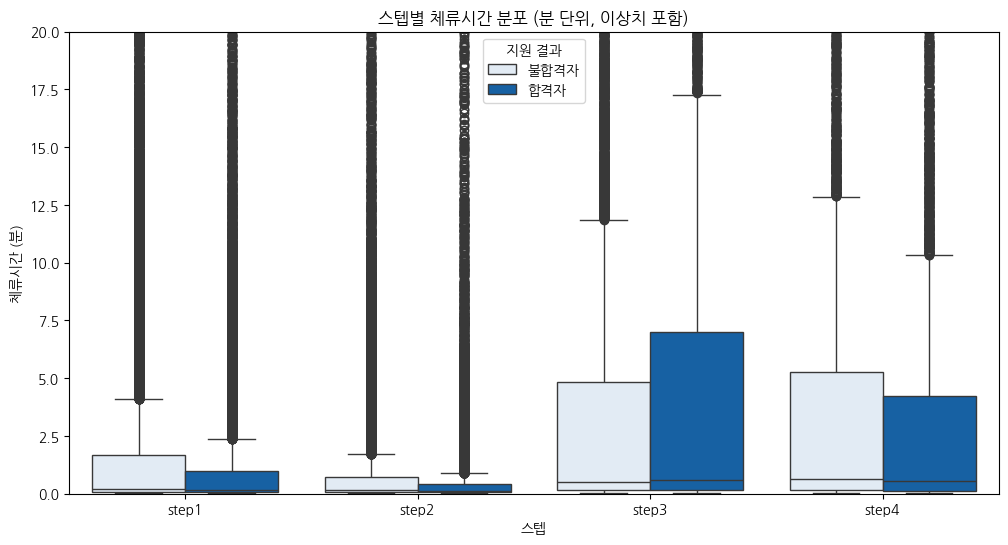

In [53]:
# 체류시간을 분 단위로 변환
step_logs["stay_minutes"] = (step_logs["stay_duration"] / 60).round(2)

# 합격자/불합격자 중에서만 확인
filtered = step_logs[step_logs["status"].isin(["합격자", "불합격자"])]

# 컬러맵 설정
custom_palette = {"불합격자": "#dfebf7", "합격자": "#0063ba"}

# Boxplot으로 이상치 확인
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered, x="step", y="stay_minutes", hue="status", palette=custom_palette)
plt.ylim(0, 20)
plt.title("스텝별 체류시간 분포 (분 단위, 이상치 포함)")
plt.ylabel("체류시간 (분)")
plt.xlabel("스텝")
plt.legend(title="지원 결과")
plt.show()

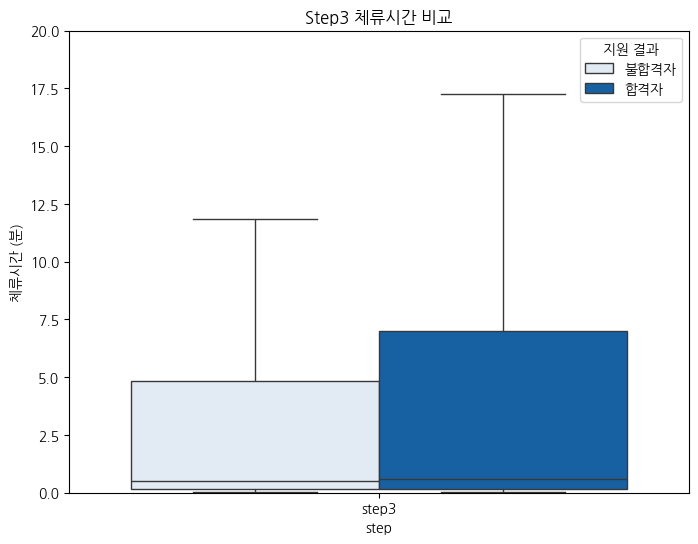

In [54]:
# step3 데이터만 필터링
step3_data = filtered[filtered["step"] == "step3"]

# 컬러맵 유지
custom_palette = {"불합격자": "#dfebf7", "합격자": "#0063ba"}

# 박스플롯 그리기 (이상치 제거: showfliers=False)
plt.figure(figsize=(8, 6))
sns.boxplot(data=step3_data, x="step", y="stay_minutes", hue="status", palette=custom_palette, showfliers=False)
plt.ylim(0, 20)
plt.title("Step3 체류시간 비교")
plt.ylabel("체류시간 (분)")
plt.legend(title="지원 결과")
plt.show()

In [55]:
from scipy.stats import ttest_ind

# 합격자와 불합격자 체류시간 추출
step3_passed = step3_data[step3_data["status"] == "합격자"]["stay_minutes"]
step3_failed = step3_data[step3_data["status"] == "불합격자"]["stay_minutes"]

# t-test 수행 (등분산 가정하지 않음 → Welch's t-test)
t_stat, p_value = ttest_ind(step3_passed, step3_failed, equal_var=False)

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("체류시간 차이가 통계적으로 유의합니다 (p < 0.05)")
else:
    print("체류시간 차이가 통계적으로 유의하지 않습니다 (p >= 0.05)")

t-statistic: -6.9296
p-value: 0.0000
체류시간 차이가 통계적으로 유의합니다 (p < 0.05)


In [56]:
# 체류시간 분 단위로 변환
step_logs["stay_minutes"] = step_logs["stay_duration"] / 60
filtered = step_logs[step_logs["status"].isin(["합격자", "불합격자"])]

# 이상치 제거 함수 정의
def remove_iqr_outliers(df):
    result = []

    for (status, step), group in df.groupby(["status", "step"]):
        q1 = group["stay_minutes"].quantile(0.25)
        q3 = group["stay_minutes"].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr

        cleaned_group = group[(group["stay_minutes"] <= upper_bound) & (group["stay_minutes"] >= lower_bound)].copy()
        result.append(cleaned_group)

    return pd.concat(result)

# IQR 기반 이상치 제거
filtered_clean = remove_iqr_outliers(filtered)

# 이상치 제거 후 평균 체류시간 재계산
mean_stats_iqr = filtered_clean.groupby(["status", "step"])["stay_minutes"].mean().reset_index()
mean_stats_iqr["stay_minutes"] = mean_stats_iqr["stay_minutes"].round(2)

mean_stats_iqr

,status,step,stay_minutes
0,불합격자,step1,0.47
1,불합격자,step2,0.30
2,불합격자,step3,1.12
3,불합격자,step4,1.16
4,합격자,step1,0.28
5,합격자,step2,0.17
6,합격자,step3,1.58
7,합격자,step4,1.04


## 합격자 vs 불합격자 리텐션 분석

### 불합격자 월별 코호트 리텐션 차트 그리기

In [57]:
loser_logs = log_df[log_df["user_uuid"].isin(total_losers_df["user_uuid"])].copy()

loser_logs["timestamp"] = pd.to_datetime(loser_logs["timestamp"])
loser_logs["activity_month"] = loser_logs["timestamp"].dt.to_period("M").dt.to_timestamp()


loser_logs["cohort_month"] = loser_logs.groupby("user_uuid")["timestamp"].transform("min").dt.to_period("M").dt.to_timestamp()


loser_logs["month_index"] = (
    (loser_logs["activity_month"].dt.to_period("M") - loser_logs["cohort_month"].dt.to_period("M"))
).apply(lambda x: x.n)

#  코호트별 월간 활동 유저 수 계산
cohort_counts = loser_logs.groupby(["cohort_month", "month_index"])["user_uuid"].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index="cohort_month", columns="month_index", values="user_uuid")

# 리텐션율 계산
cohort_sizes = cohort_pivot[0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0).round(3)

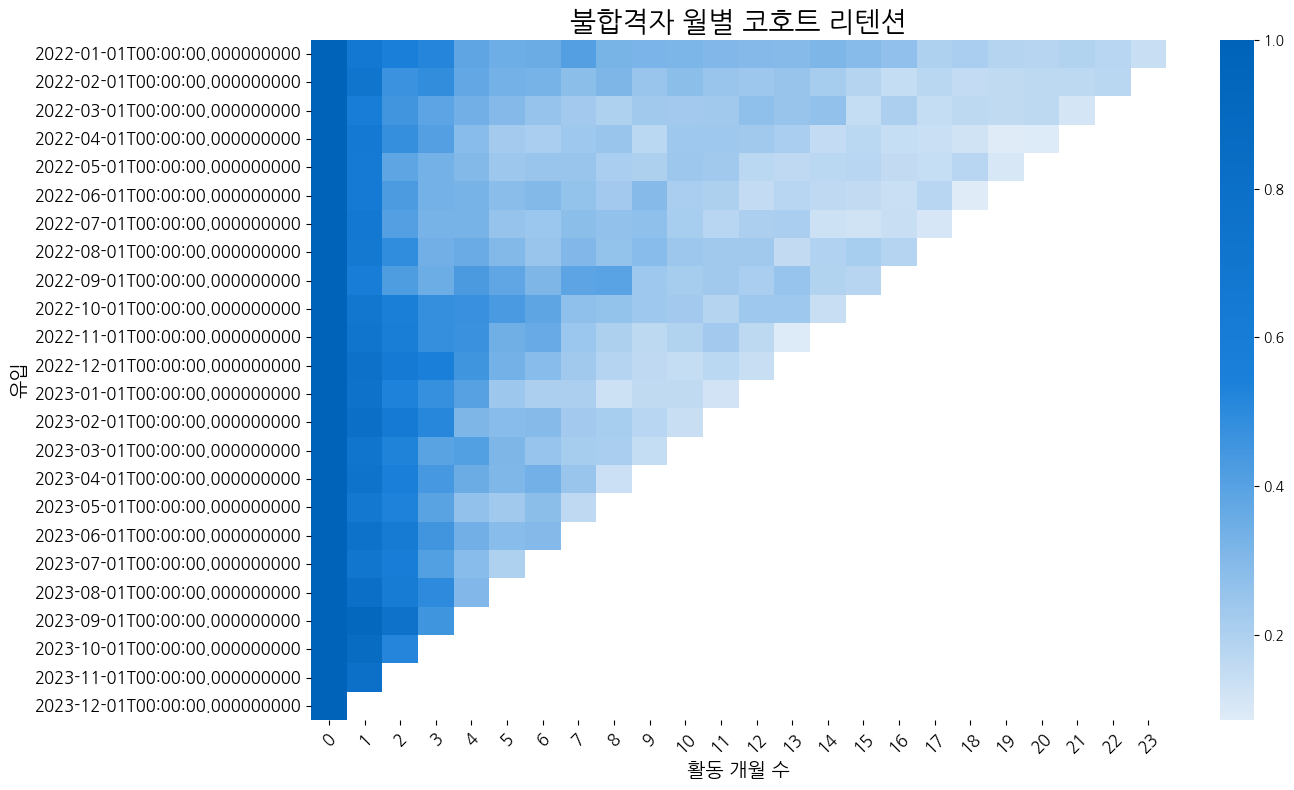

In [58]:
plt.figure(figsize=(14, 8))  # 조금 더 크게
sns.heatmap(retention_matrix, annot=False, cmap=custom_cmap)

# 제목과 축 폰트 사이즈 조정
plt.title("불합격자 월별 코호트 리텐션", fontsize=20)
plt.xlabel("활동 개월 수", fontsize=14)
plt.ylabel("유입", fontsize=14)

# x축, y축 눈금 글자 크기 키우기
plt.xticks(fontsize=12, rotation=45)  # x축 살짝 기울이기
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

```python
plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title("불합격자 월별 코호트 리텐션")
plt.xlabel("활동 개월 수")
plt.ylabel("유입 ")
plt.tight_layout()
plt.show()
```

### 합격자 월별 코호트 리텐션 차트 그리기

In [59]:
total_application_passed_df["timestamp"] = pd.to_datetime(total_application_passed_df["timestamp"])
total_application_passed_df["activity_month"] = total_application_passed_df["timestamp"].dt.to_period("M").dt.to_timestamp()


total_application_passed_df["cohort_month"] = total_application_passed_df.groupby("user_uuid")["timestamp"].transform("min").dt.to_period("M").dt.to_timestamp()


total_application_passed_df["month_index"] = (
    (total_application_passed_df["activity_month"].dt.to_period("M") - total_application_passed_df["cohort_month"].dt.to_period("M"))
).apply(lambda x: x.n)

#  코호트별 월간 활동 유저 수 계산
cohort_counts = total_application_passed_df.groupby(["cohort_month", "month_index"])["user_uuid"].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index="cohort_month", columns="month_index", values="user_uuid")

# 리텐션율 계산
cohort_sizes = cohort_pivot[0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0).round(3)

<ipython-input-59-ed5daa572d14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_application_passed_df["timestamp"] = pd.to_datetime(total_application_passed_df["timestamp"])
<ipython-input-59-ed5daa572d14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_application_passed_df["activity_month"] = total_application_passed_df["timestamp"].dt.to_period("M").dt.to_timestamp()
<ipython-input-59-ed5daa572d14>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [60]:
# 2022-01-01 이후 코호트만 남기기
retention_matrix = retention_matrix[retention_matrix.index >= '2022-01-01']

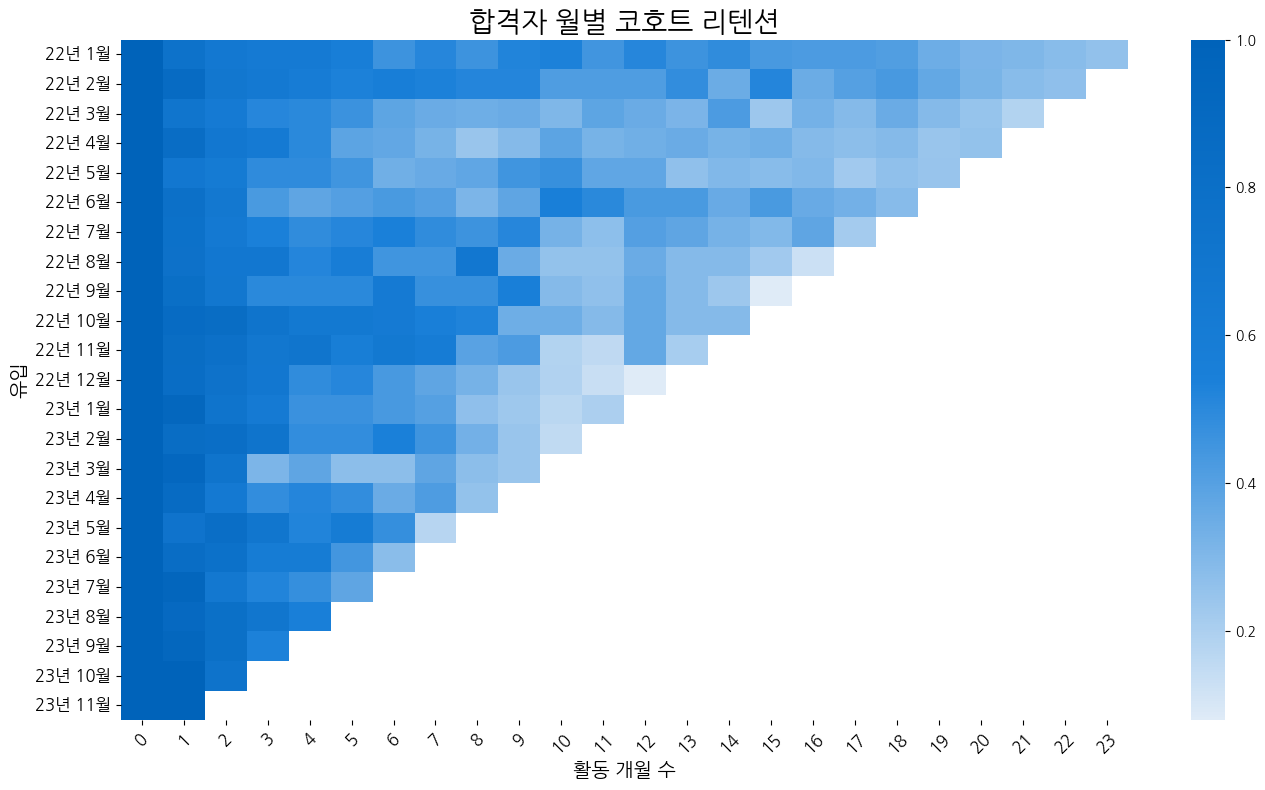

In [61]:
plt.figure(figsize=(14, 8))
sns.heatmap(retention_matrix, annot=False, cmap=custom_cmap)

# 제목과 축 폰트 사이즈 조정
plt.title("합격자 월별 코호트 리텐션", fontsize=20)
plt.xlabel("활동 개월 수", fontsize=14)
plt.ylabel("유입", fontsize=14)

# x축, y축 눈금 글자 크기 키우기
plt.xticks(fontsize=12, rotation=45)

# y축 날짜 포맷 수정
new_labels = [f"{d.year % 100}년 {d.month}월" for d in retention_matrix.index]
plt.yticks(ticks=np.arange(len(new_labels)) + 0.5, labels=new_labels, fontsize=12)

plt.tight_layout()
plt.show()

```python
plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title("합격자 월별 코호트 리텐션")
plt.xlabel("활동 개월 수")
plt.ylabel("유입 ")
plt.tight_layout()
plt.show()
```

### 불합격자 수 2,785명(random_losers_df)으로 다시 해보기

In [62]:
loser_members = total_losers_df["user_uuid"].unique()

random_loser_members = np.random.choice(loser_members, size=2785, replace=False)

random_losers_df = total_losers_df[total_losers_df["user_uuid"].isin(random_loser_members)]

In [63]:
loser_logs = log_df[log_df["user_uuid"].isin(random_losers_df["user_uuid"])].copy()

loser_logs["timestamp"] = pd.to_datetime(loser_logs["timestamp"])
loser_logs["activity_month"] = loser_logs["timestamp"].dt.to_period("M").dt.to_timestamp()


loser_logs["cohort_month"] = loser_logs.groupby("user_uuid")["timestamp"].transform("min").dt.to_period("M").dt.to_timestamp()


loser_logs["month_index"] = (
    (loser_logs["activity_month"].dt.to_period("M") - loser_logs["cohort_month"].dt.to_period("M"))
).apply(lambda x: x.n)

#  코호트별 월간 활동 유저 수 계산
cohort_counts = loser_logs.groupby(["cohort_month", "month_index"])["user_uuid"].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index="cohort_month", columns="month_index", values="user_uuid")

# 리텐션율 계산
cohort_sizes = cohort_pivot[0]
retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0).round(3)

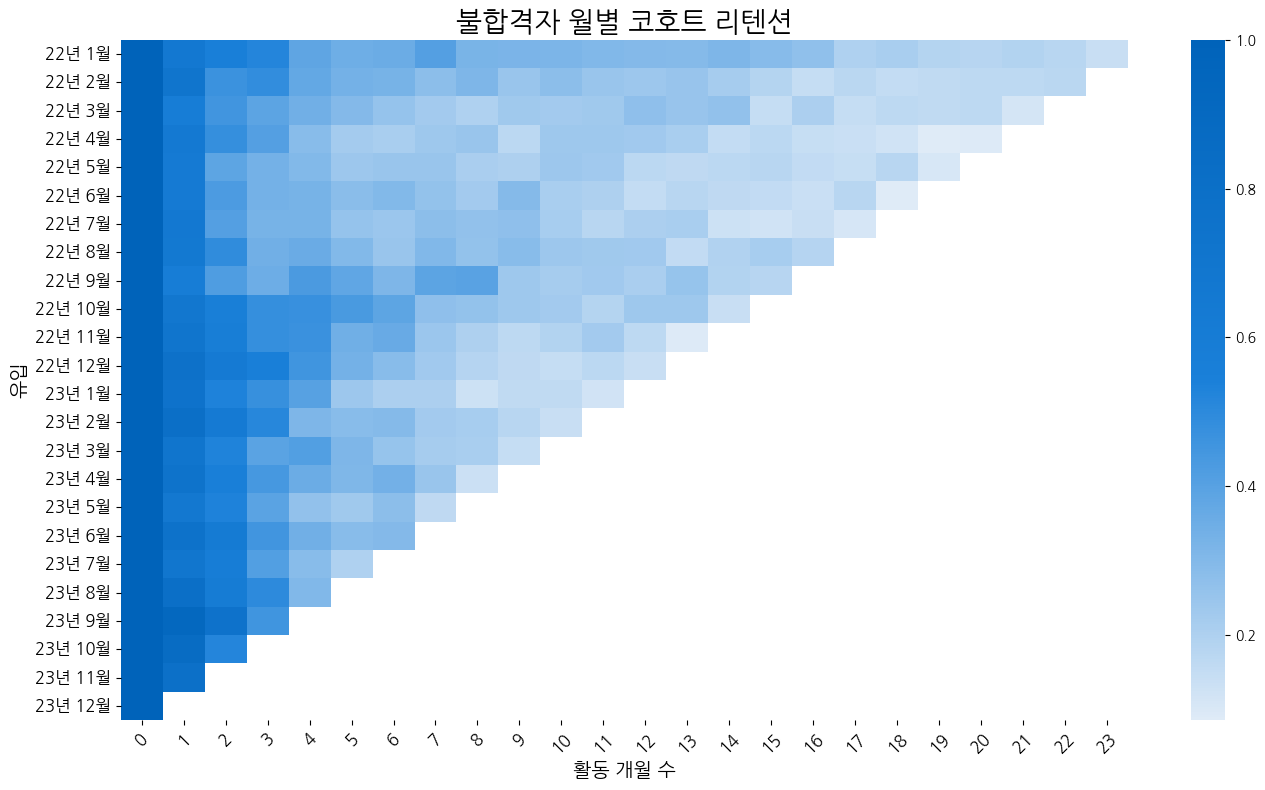

In [64]:
plt.figure(figsize=(14, 8))
sns.heatmap(retention_matrix, annot=False, cmap=custom_cmap)

# 제목과 축 폰트 사이즈 조정
plt.title("불합격자 월별 코호트 리텐션", fontsize=20)
plt.xlabel("활동 개월 수", fontsize=14)
plt.ylabel("유입", fontsize=14)

# x축, y축 눈금 글자 크기 키우기
plt.xticks(fontsize=12, rotation=45)

# y축 날짜 포맷 수정
new_labels = [f"{d.year % 100}년 {d.month}월" for d in retention_matrix.index]
plt.yticks(ticks=np.arange(len(new_labels)) + 0.5, labels=new_labels, fontsize=12)

plt.tight_layout()
plt.show()

```python
plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title("랜덤 불합격자 월별 코호트 리텐션")
plt.xlabel("활동 개월 수")
plt.ylabel("유입 ")
plt.tight_layout()
plt.show()
```

## 합격자와 불합격자 중 누가 더 지원을 많이 했는가?

In [65]:
# Step 1: 특정 cleaned_url 값 필터링
losers_apply_complete_df = total_losers_df[total_losers_df['cleaned_url'] == 'api/jobs/id/apply/step4']

# Step 2: user_uuid별로 groupby 후 count
losers_apply_complete_counts = losers_apply_complete_df.groupby('user_uuid').size()

# Step 3: 평균 계산
losers_apply_complete_average_count = losers_apply_complete_counts.mean()

print(f"불합격자의 평균 지원 완료 횟수: {losers_apply_complete_average_count}")

불합격자의 평균 지원 완료 횟수: 5.6262118491921


In [66]:
# Step 1: 특정 cleaned_url 값 필터링
passed_apply_complete_df = total_application_passed_df[total_application_passed_df['cleaned_url'] == 'api/jobs/id/apply/step4']

# Step 2: user_uuid별로 groupby 후 count
passed_apply_complete_counts = passed_apply_complete_df.groupby('user_uuid').size()

# Step 3: 평균 계산
passed_apply_complete_average_count = passed_apply_complete_counts.mean()

print(f"합격자의 평균 지원 완료 횟수: {passed_apply_complete_average_count}")

합격자의 평균 지원 완료 횟수: 14.99641577060932


## 구GPT의 합불 행동 패턴 분석

In [67]:
passed_users = set(total_application_passed_df['user_uuid'])
failed_users = set(total_losers_df['user_uuid'])


log_df['status'] = log_df['user_uuid'].apply(
    lambda x: '합격자' if x in passed_users else ('불합격자' if x in failed_users else '기타')
)

# 합격자와 불합격자의 행동 패턴 비교, URL 기준 상위 20개 행동 비교
log_counts = log_df[log_df['status'].isin(['합격자', '불합격자'])] \
    .groupby(['status', 'cleaned_url'])['user_uuid'].count().reset_index()
log_counts.columns = ['status', 'cleaned_url', 'count']

# 상위 20개 행동
top_passed = log_counts[log_counts['status'] == '합격자'].sort_values(by='count', ascending=False).head(20)
top_failed = log_counts[log_counts['status'] == '불합격자'].sort_values(by='count', ascending=False).head(20)

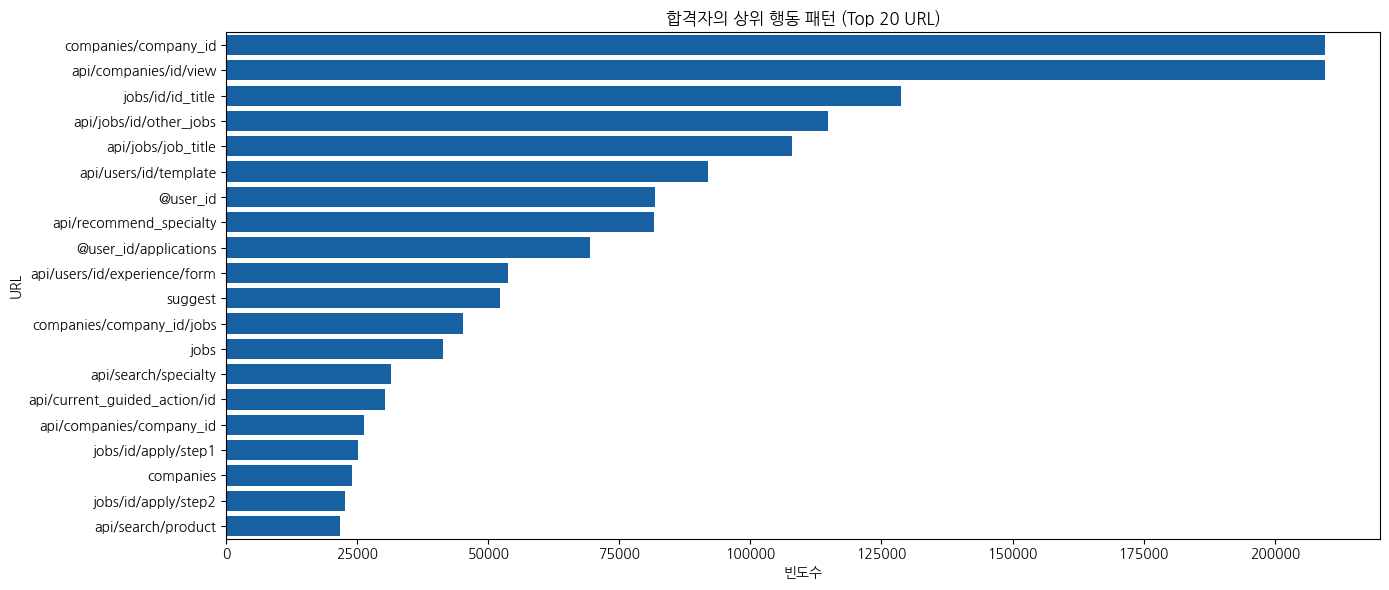

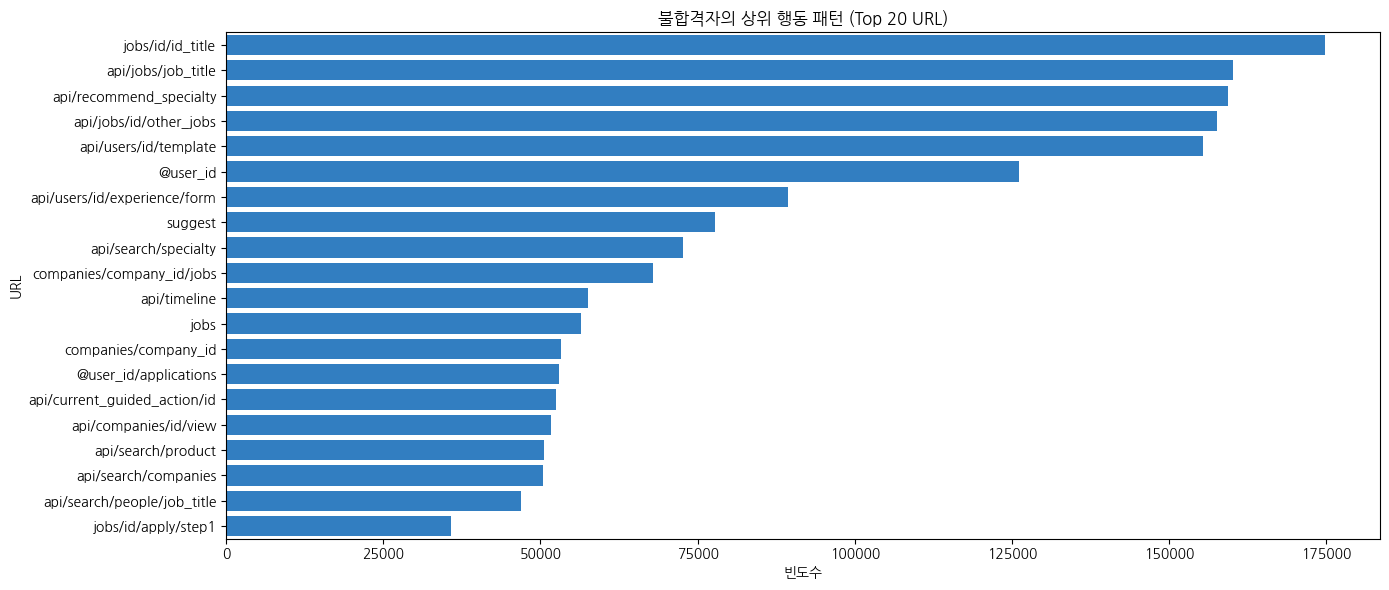

In [69]:
plt.figure(figsize=(14, 6))
sns.barplot(data=top_passed, x='count', y='cleaned_url', color='#0063ba')
plt.title("합격자의 상위 행동 패턴 (Top 20 URL)")
plt.xlabel("빈도수")
plt.ylabel("URL")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(data=top_failed, x='count', y='cleaned_url', color='#1a80d9')
plt.title("불합격자의 상위 행동 패턴 (Top 20 URL)")
plt.xlabel("빈도수")
plt.ylabel("URL")
plt.tight_layout()
plt.show()

## step3 후 로그 확인 (step3 경로에 도달한 후 어떤 행동을 하는가)

In [70]:
# 유저별로 timestamp 순 정렬
log_df = log_df.sort_values(by=['user_uuid', 'timestamp'])

### step3 이후 5개

In [71]:
# 결과 저장할 리스트
results = []

# 유저별로 그룹핑
for user, group in log_df.groupby('user_uuid'):
    group = group.reset_index(drop=True)

    # 'jobs/id/apply/step3'이 처음 등장하는 인덱스 찾기
    match_indices = group.index[group['cleaned_url'] == 'jobs/id/apply/step3'].tolist()

    for idx in match_indices:
        # 이후 10개의 로그 추출 (idx 포함해서 총 10개)
        subset = group.iloc[idx:idx+5]
        results.append(subset)

# 결과 합치기
after_step3_df = pd.concat(results, ignore_index=True)

# 결과 출력 (또는 저장 등)
after_step3_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,status
0,449933,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step3,2022-06-11 23:06:11.008202,2022-06-12,200,GET,jobs/id/apply/step3,기타
1,449922,0002535c-eacb-456b-a620-92c917332ba3,api/jobs/id/apply/step3,2022-06-11 23:06:16.756018,2022-06-12,400,POST,api/jobs/id/apply/step3,기타
2,449997,0002535c-eacb-456b-a620-92c917332ba3,continue?next=/@kyungmeejung/job_offer/received,2022-06-21 02:20:46.512750,2022-06-21,302,GET,continue,기타
3,449859,0002535c-eacb-456b-a620-92c917332ba3,@user_id/job_offer/received?utm_source=notific...,2022-06-21 02:20:47.094849,2022-06-21,200,GET,@user_id/job_offer/received,기타
4,450014,0002535c-eacb-456b-a620-92c917332ba3,api/job_offer/id/modal?type=received&_=1655778...,2022-06-21 02:21:01.616304,2022-06-21,200,GET,api/job_offer/id/modal,기타
...,...,...,...,...,...,...,...,...,...
586964,1776626,ffff25ca-c1d7-4fc2-891b-b0df92f95092,jobs/id/apply/step3,2023-11-29 14:23:33.639992,2023-11-29,200,GET,jobs/id/apply/step3,기타
586965,1776621,ffff25ca-c1d7-4fc2-891b-b0df92f95092,api/jobs/id/apply/step3,2023-11-29 14:23:41.449743,2023-11-29,200,POST,api/jobs/id/apply/step3,기타
586966,1776716,ffff25ca-c1d7-4fc2-891b-b0df92f95092,jobs/id/apply/step4,2023-11-29 14:23:42.002444,2023-11-29,200,GET,jobs/id/apply/step4,기타
586967,1776649,ffff25ca-c1d7-4fc2-891b-b0df92f95092,api/jobs/id/apply/step4,2023-11-29 14:23:45.753890,2023-11-29,200,POST,api/jobs/id/apply/step4,기타


In [ ]:
# step3 이후의 행동만 추출 (step3 자체는 제외)
after_only_df = after_step3_df[after_step3_df['cleaned_url'] != 'jobs/id/apply/step3']

# 행동별 전체 카운트 집계
after_step3_top10_actions = (
    after_only_df['cleaned_url']
    .value_counts()
    .reset_index()
)

# 컬럼 이름 정리
after_step3_top10_actions.columns = ['cleaned_url', 'count']

# 결과 출력
after_step3_top10_actions

,cleaned_url,count
0,api/jobs/id/apply/step3,79494
1,jobs/id/apply/step4,55964
2,api/jobs/id/apply/step4,41803
3,jobs/id/id_title,37172
4,api/jobs/id/other_jobs,21198
...,...,...
180,api/comments,1
181,api/users/id/profile_image,1
182,api/companies/id/reference/id,1
183,email_security,1


### step3 바로 직후

In [ ]:
# 결과 저장할 리스트
results = []

# 유저별로 그룹핑
for user, group in log_df.groupby('user_uuid'):
    group = group.reset_index(drop=True)

    # 'jobs/id/apply/step3'이 처음 등장하는 인덱스 찾기
    match_indices = group.index[group['cleaned_url'] == 'jobs/id/apply/step3'].tolist()

    for idx in match_indices:
        # 이후 10개의 로그 추출 (idx 포함해서 총 10개)
        subset = group.iloc[idx:idx+2]
        results.append(subset)

# 결과 합치기
next_step3_df = pd.concat(results, ignore_index=True)

# 결과 출력 (또는 저장 등)
next_step3_df

,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,cleaned_url,status
0,449933,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step3,2022-06-11 23:06:11.008202,2022-06-12,200,GET,jobs/id/apply/step3,기타
1,449922,0002535c-eacb-456b-a620-92c917332ba3,api/jobs/id/apply/step3,2022-06-11 23:06:16.756018,2022-06-12,400,POST,api/jobs/id/apply/step3,기타
2,449877,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step3,2022-07-23 04:06:52.749883,2022-07-23,200,GET,jobs/id/apply/step3,기타
3,449937,0002535c-eacb-456b-a620-92c917332ba3,api/jobs/id/apply/step3,2022-07-23 04:07:41.363913,2022-07-23,200,POST,api/jobs/id/apply/step3,기타
4,449852,0002535c-eacb-456b-a620-92c917332ba3,jobs/id/apply/step3,2022-07-23 04:08:24.788796,2022-07-23,200,GET,jobs/id/apply/step3,기타
...,...,...,...,...,...,...,...,...,...
234929,1776599,ffff25ca-c1d7-4fc2-891b-b0df92f95092,api/jobs/id/apply/step3,2023-11-29 14:16:59.666569,2023-11-29,200,POST,api/jobs/id/apply/step3,기타
234930,1776609,ffff25ca-c1d7-4fc2-891b-b0df92f95092,jobs/id/apply/step3,2023-11-29 14:19:40.618461,2023-11-29,200,GET,jobs/id/apply/step3,기타
234931,1776657,ffff25ca-c1d7-4fc2-891b-b0df92f95092,api/jobs/id/apply/step3,2023-11-29 14:19:53.102233,2023-11-29,200,POST,api/jobs/id/apply/step3,기타
234932,1776626,ffff25ca-c1d7-4fc2-891b-b0df92f95092,jobs/id/apply/step3,2023-11-29 14:23:33.639992,2023-11-29,200,GET,jobs/id/apply/step3,기타


In [ ]:
# step3 이후의 행동만 추출 (step3 자체는 제외)
next_only_df = next_step3_df[next_step3_df['cleaned_url'] != 'jobs/id/apply/step3']

# 행동별 전체 카운트 집계
next_step3_top10_actions = (
    next_only_df['cleaned_url']
    .value_counts()
    .reset_index()
)

# 컬럼 이름 정리
next_step3_top10_actions.columns = ['cleaned_url', 'count']

# 결과 출력
next_step3_top10_actions

,cleaned_url,count
0,api/jobs/id/apply/step3,59631
1,jobs/id/apply/step2,11506
2,jobs/id/id_title,9299
3,jobs/id/apply/step1,3966
4,companies/company_id/jobs,3956
...,...,...
124,email_security,1
125,companies/company_id/jobs/job_title,1
126,api/users/id/language,1
127,api/references,1


# 정리

- 22년 23년 합격자와 불합격자의 상위 20개 행동에는 약간의 차이 있음
    - 22년 불합격자는 지원과 관련된 행동을 잘 하지 않는데 23년 불합격자는 지원과 관련된 행동을 조금 함
    - 23년에 지원과 관련된 행동을 하긴 하지만 적극적으로 지원을 완료하지 않음

- 22년 23년 합격자와 불합격자의 지원 이후 리텐션은 비슷한 경향을 보임
    - 불합격자보다 합격자의 리텐션이 더 높은 편

- 22년 23년을 합쳐서 보더라도 비슷한 경향

- 신규 회원가입을 완료하고 첫 지원을 완료한 활성화 유저에 대해 리텐션을 개선하기 위한 방안을 모색
    - 지원한 공고에 합격하면 유저에게 긍정적인 경험으로 인지됨
        - 근거: 합격자와 불합격자의 지원 완료 후 리텐션 비교
    - 공고 지원 페이지에서 합격률을 높이는 가이드라인 제시
        - 근거: step3에서 체류시간이 가장 길었음 -> step3에서 작성할 내용 가장 많음
            - 합격자와 불합격자의 step3 체류시간을 비교했을 때 합격자의 체류시간이 더 길었음 -> step3에서 더 자세하게 내용을 작성하면 합격률이 오름
    - 공고 지원 적극성 높이는 멘트 ("많은 사람이 관심을 갖는 공고예요. 지원해보세요.", "공고 마감이 얼마 남지 않았어요." 등)
        - 근거: 합격자와 불합격자의 행동을 비교하였을 때 합격자가 더 적극적으로 지원하고 지원을 완료하는 경향이 있음

# 발표

1. AARRR 한바퀴 돌린 것 설명
    - 획득: 신규 회원가입 완료
    - 활성화: 최초 지원완료 -> 지원 완료 경험이 있는 유저
        - AHA 모먼트: 지원 완료
    - 리텐션: 낮았어 -> 개선해야해
    - 수익화: 우리 플랫폼을 통해 지원한 지원자가 합격을 하게 되면 수수료가 들어올 수 있다. (확인 했다 vs 다양한 수익화 모델 중 하나)

2. 지원을 완료한 사람들 비교 (서류 합격자 vs 서류 불합격자)
    - 이유: 우리의 활성화 유저는 지원 완료 경험이 있는 유저니깐~
    - 합격자가 불합격자보다 리텐션이 높더라 -> 서류 합격은 우리 플랫폼 이용 유저에게 긍정적인 경험이야
        - 왜 서류합격? -> 서류 이후 면접에 관련된 부분은 플랫폼 내에서 통제할 수 있는 요인이 아니기 때문
            - 추후에 면접을 보고 온 유저에게 후기 작성 유도해서 -> 면접 가이드라인도 제시 (질문시 대답)
    - 서류 합격 확률을 높이는 행동을 취하면 유저들의 서비스 만족도가 늘어날거야 -> 리텐션이 개선될거야

3. 유저의 서류 합격 확률을 높이기 위한 우리 플랫폼의 행동
    - 공고 지원 페이지에서 합격률을 높이는 가이드라인 제시
        - 근거: step3에서 체류시간이 가장 길었음 -> step3에서 작성할 내용 가장 많음
            - 합격자와 불합격자의 step3 체류시간을 비교했을 때 합격자의 체류시간이 더 길었음 -> step3에서 더 자세하게 내용을 작성하면 합격률이 오름
    - 공고 지원 적극성 높이는 멘트 ("많은 사람이 관심을 갖는 공고예요. 지원해보세요.", "공고 마감이 얼마 남지 않았어요." 등)
        - 근거: 합격자와 불합격자의 행동을 비교하였을 때 합격자가 더 적극적으로 지원하고 지원을 완료하는 경향이 있음

4. 예상 시나리오?
    - 아까 영주님이 찾아주신 페이지 참고해서 예상 페이지 제작 해야함
        - 개선 페이지: 공고 지원 적극성 높여주는 멘트 팝업, 공고 지원서 작성할 때 "이렇게 작성하면 합격률이 ~% 올라가요!" 이런 멘트 추가
    - 합격률이 올라간다 -> 합격하는 지원자가 많아진다 -> 수수료 수익이 늘어난다

돼성요

돼지예요 다이어트를

성공하고싶어요

요요 없이

나요

조쾨해요

좋게좋게 조쾨해요

# 발표자료를 어떻게 만들 것인가?

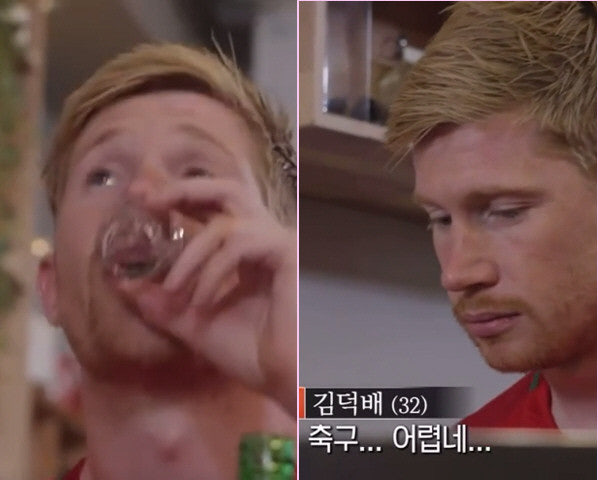

류제범(27)

발표...어렵네...